In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet

### 실습 1

- 당뇨병 발생을 예측하기 위해 회귀분석을 실시하고 결과를 해석하시오
- 당뇨병 발병 원인과 관련된 데이터 (변수: 11개, 자료 수: 442개)

#### step 1. 데이터 구성하기 

In [2]:
df_raw = pd.read_csv('/home/piai/PABA_27/BigData/lecture/01 실습파일/2. Big Data 분석/DIABETES.csv', encoding='cp949')
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [3]:
# 요약 통계량 
df_raw.describe()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,152.133484,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181
std,77.093005,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335
min,25.000000,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,87.000000,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000
50%,140.500000,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,211.500000,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,346.000000,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


In [4]:
# GENDER 열의 값 2를 0으로 변환 
df_raw['GENDER'] = df_raw['GENDER'].replace({2:0})
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


- 기존 데이터에서는 GENDER 값이 1과 2로 이루어져 있다. (배수의 관계) 
- replace 함수를 사용하여 dummy 변수로 변환해준다. 

step 2. 변수 간의 경향성 파악: 그래프 분석

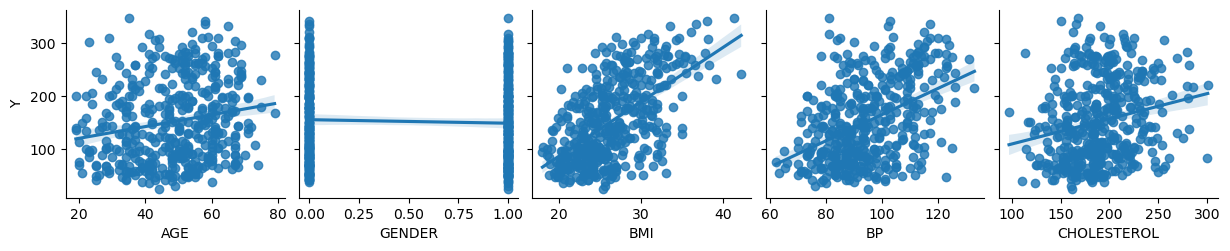

In [5]:
# 그래프 분석 - 산점도 행렬 
sns.pairplot(df_raw, y_vars= "Y",x_vars=["AGE", "GENDER", "BMI", "BP", "CHOLESTEROL"], kind="reg")

- Y 변수와 다른 변수들 사이의 관계를 보여준다. 
- AGE(나이): 매우 약한 양의 상관관계 
- GENDER(성별): Y변수와 성별 사이에 뚜렷한 패턴은 없다. (이산형)
- BMI(체질량 지수): 약한 양의 상관관계
- BP(혈압): 비교적 명확한 양의 상관관계 
- CHOLESTEROL(콜레스테롤): 비교적 강한 양의 상관관계

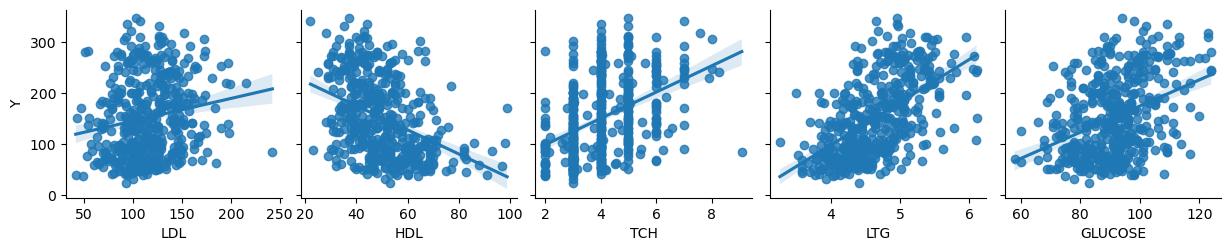

In [6]:
sns.pairplot(df_raw, y_vars="Y", x_vars=["LDL", "HDL", "TCH", "LTG", "GLUCOSE"], kind="reg")

- LDL(저밀도 지단백 콜레스테롤): 약한 양의 상관관계
- HDL(고밀도 지단백 콜레스테롤) 뚜렷한 패턴이 없다. (약한 음의 상관관계)
- TCH(총 콜레스테롤): 비교적 강한 양의 상관관계
- LTG(중성지방): 중간 정도의 양의 상관관계
- GLUCOSE(혈당수치): 비교적 강한 양의 상관관계

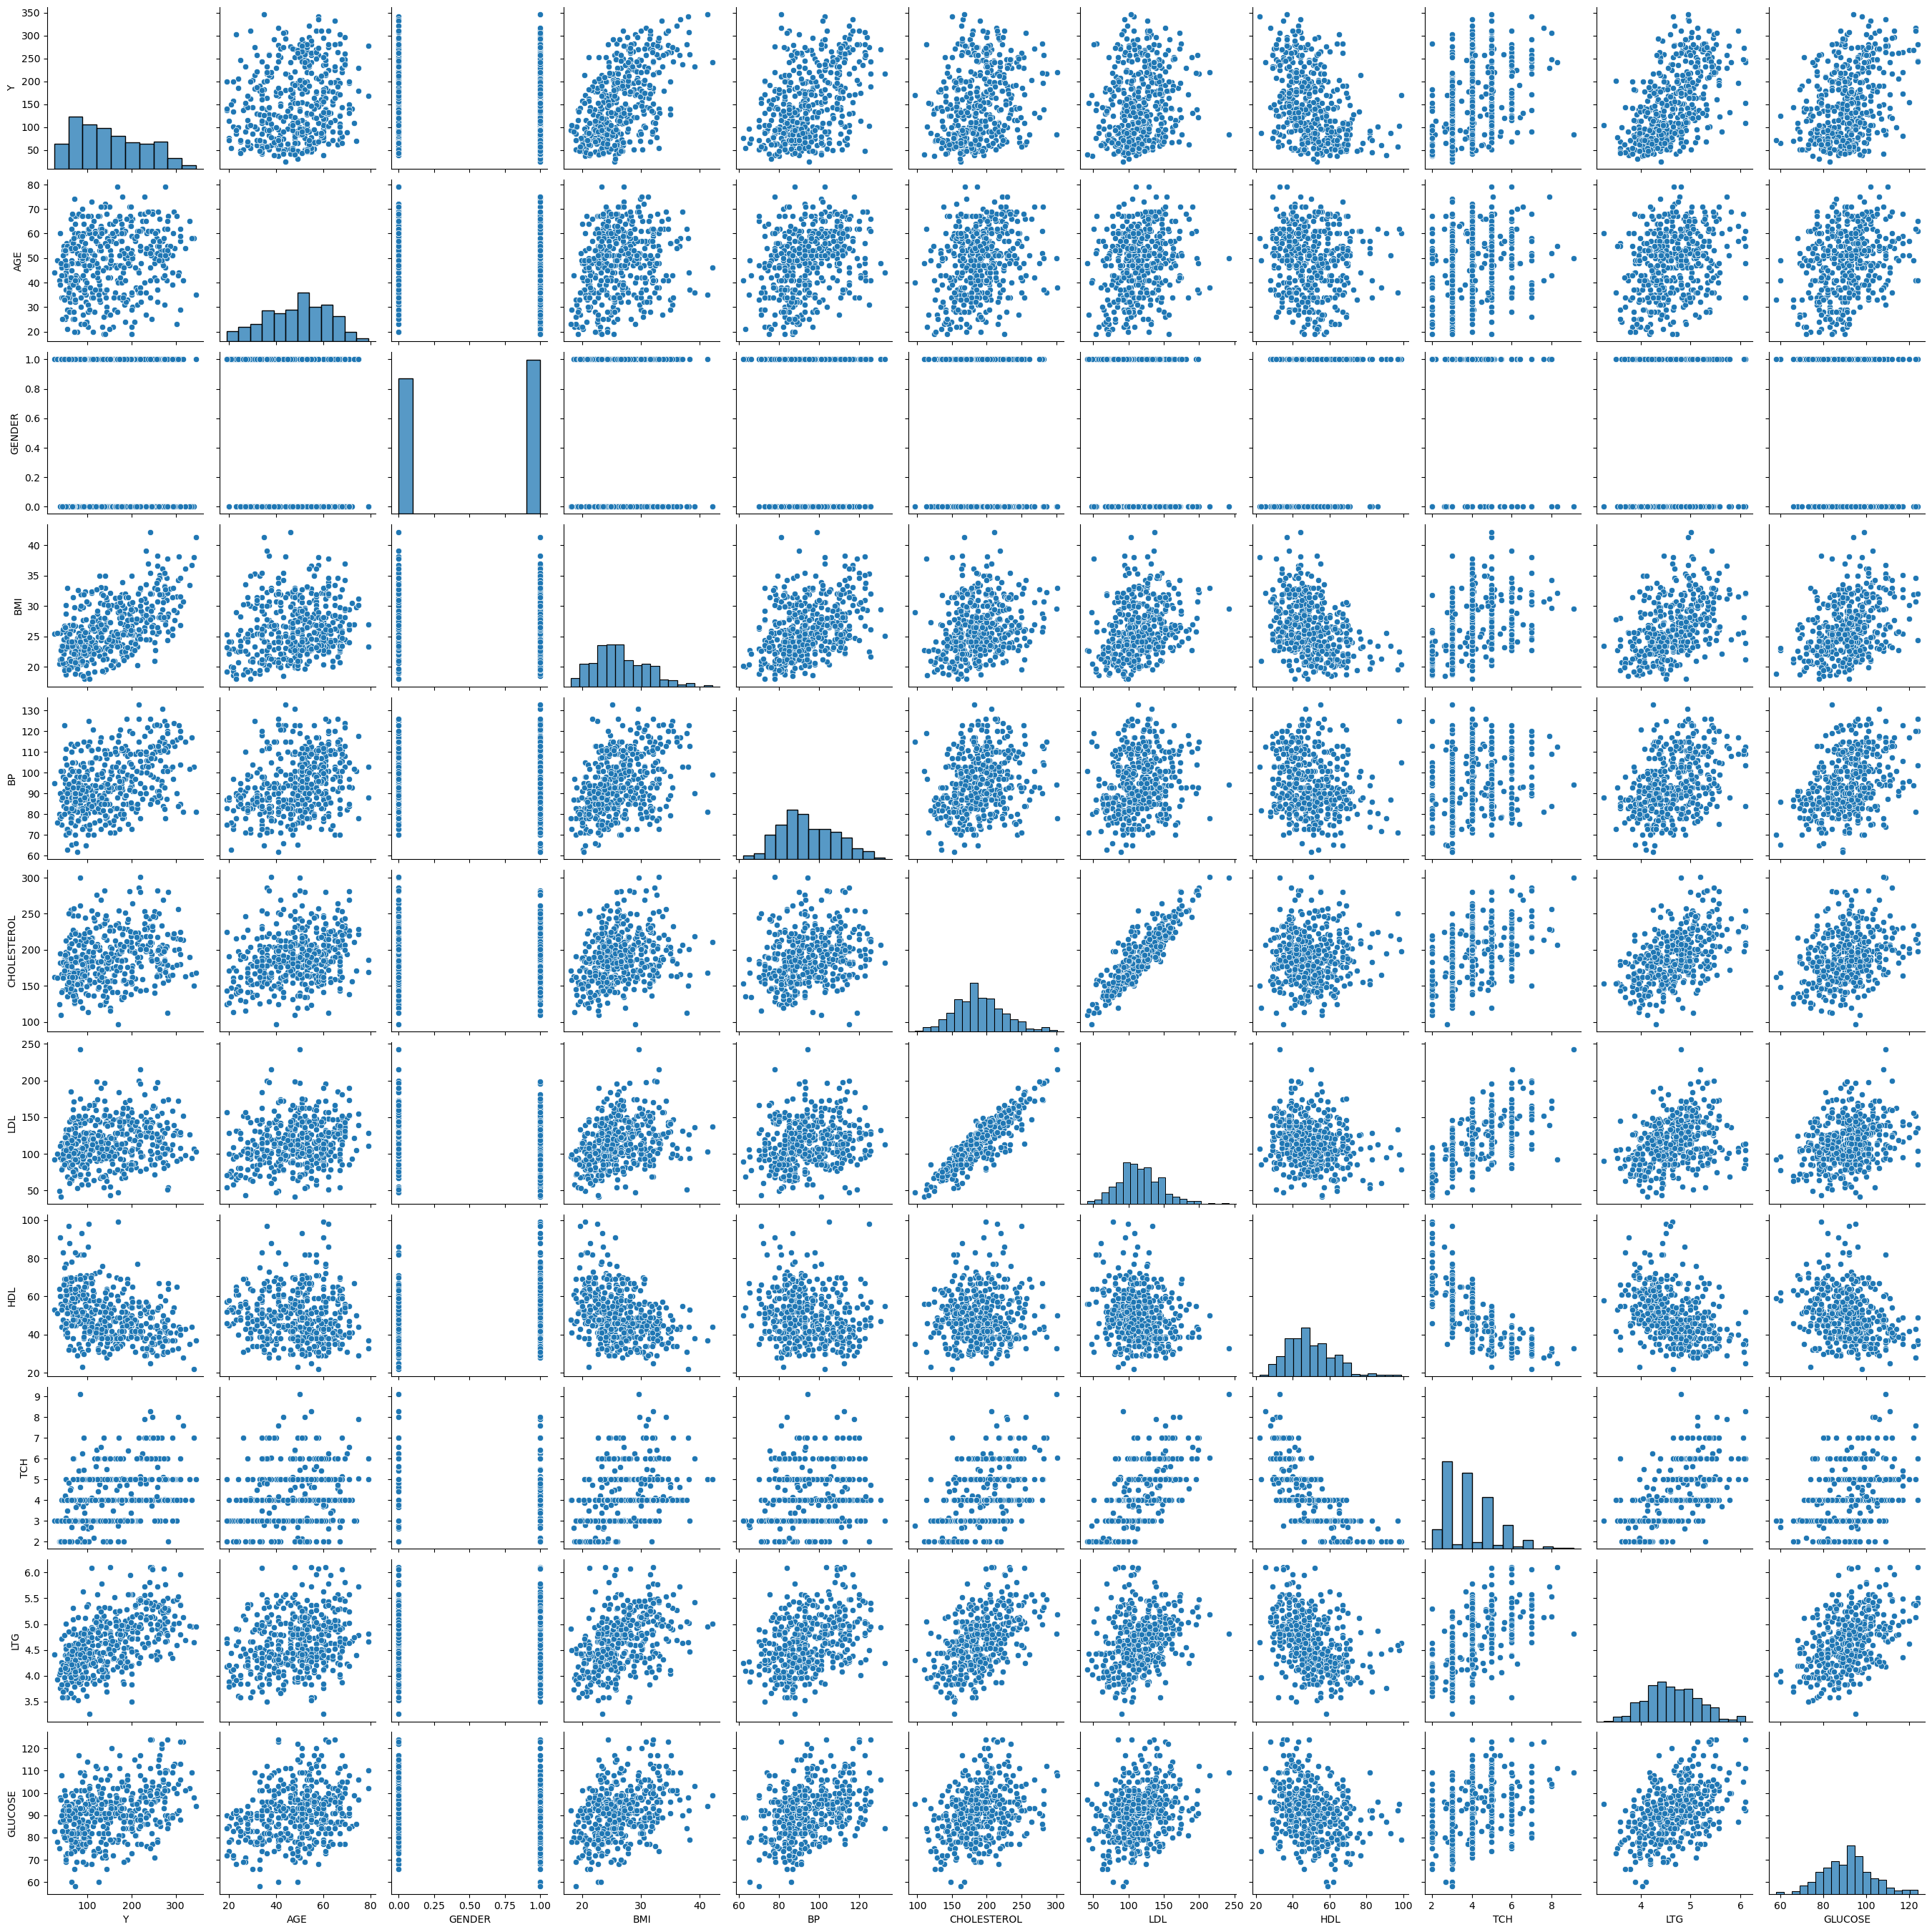

In [7]:
sns.pairplot(df_raw)

In [8]:
# 상관관계 분석 
df_raw.corr().round(3)

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
Y,1.000,0.188,-0.043,0.586,0.441,0.212,0.174,-0.395,0.430,0.566,0.382
AGE,0.188,1.000,-0.174,0.185,0.335,0.260,0.219,-0.075,0.204,0.271,0.302
GENDER,-0.043,-0.174,1.000,-0.088,-0.241,-0.035,-0.143,0.379,-0.332,-0.150,-0.208
BMI,0.586,0.185,-0.088,1.000,0.395,0.250,0.261,-0.367,0.414,0.446,0.389
BP,0.441,0.335,-0.241,0.395,1.000,0.242,0.186,-0.179,0.258,0.393,0.390
CHOLESTEROL,0.212,0.260,-0.035,0.250,0.242,1.000,0.897,0.052,0.542,0.516,0.326
LDL,0.174,0.219,-0.143,0.261,0.186,0.897,1.000,-0.196,0.660,0.318,0.291
HDL,-0.395,-0.075,0.379,-0.367,-0.179,0.052,-0.196,1.000,-0.738,-0.399,-0.274
TCH,0.430,0.204,-0.332,0.414,0.258,0.542,0.660,-0.738,1.000,0.618,0.417
LTG,0.566,0.271,-0.150,0.446,0.393,0.516,0.318,-0.399,0.618,1.000,0.465


- LDL과 CHOLESTEROL이 0.897로 높은 양의 상관관계를 가진다. 
- 그 다음으로는, LDL과 TCH가 0.660으로 양의 상관관계를 가진다.

In [9]:
# train/ test data 분리
df_train, df_test = train_test_split(df_raw, test_size= 0.3, random_state=1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (309, 11)
test data size : (133, 11)


#### step 3. 회귀 모델 생성 
- 모델의 적합성 검토 (분산분석/ 결정계수 확인)
- 회귀계수 유의성 검토 (표준화 회귀계수 포함)
- 다중공선성 검토 

In [10]:
# 선형 회귀 분석
reg_model = smf.ols(formula = "Y~ AGE + GENDER + BMI + BP + CHOLESTEROL + LDL + HDL + TCH + LTG + GLUCOSE", data=df_train)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     33.24
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           5.68e-43
Time:                        23:22:14   Log-Likelihood:                -1668.9
No. Observations:                 309   AIC:                             3360.
Df Residuals:                     298   BIC:                             3401.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -388.4742     85.987     -4.518      

- 유의하지 않은 변수 중 p_value가 0.05 이상이면서 그 중에서도 가장 큰 것부터 하나씩 제거 
- HDL, AGE가 차례로 제거되었다.
- 남은 변수는 GENDER, BMI, BP, CHOLESTEROL, LDL, TCH, LTG, GLUCOSE이다.

In [11]:
# 선형 회귀 분석
# HDL 제거 
reg_model = smf.ols(formula = "Y~ AGE + GENDER + BMI + BP + CHOLESTEROL + LDL + TCH + LTG + GLUCOSE", data=df_train)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     37.04
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           9.36e-44
Time:                        23:22:14   Log-Likelihood:                -1668.9
No. Observations:                 309   AIC:                             3358.
Df Residuals:                     299   BIC:                             3395.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -368.4439     39.939     -9.225      

In [12]:
# 선형 회귀 분석
# AGE 제거 
reg_model = smf.ols(formula = "Y~ GENDER + BMI + BP + CHOLESTEROL + LDL + TCH + LTG + GLUCOSE", data=df_train)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     41.78
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.48e-44
Time:                        23:22:14   Log-Likelihood:                -1669.0
No. Observations:                 309   AIC:                             3356.
Df Residuals:                     300   BIC:                             3390.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -368.4824     39.880     -9.240      

In [13]:
# 다중공선성 확인 
# GENDER, BMI, BP, CHOLESTEROL, LDL, TCH, LTG, GLUCOSE
df_train_x = df_train.drop(["GENDER", "BMI", "BP", "CHOLESTEROL", "LDL", "TCH", "LTG", "GLUCOSE"], axis=1)
df_train_x_const = add_constant(df_train_x)

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

# VIF 정렬
df_vif.sort_values("VIF", inplace=True)
df_vif

,variable,VIF
2,AGE,1.031460
3,HDL,1.199263
1,Y,1.222431
0,const,42.933427


- VIF 값이 10상인 변수가 없어 다중공선성이 있는 변수는 없다고 볼 수 있다. 

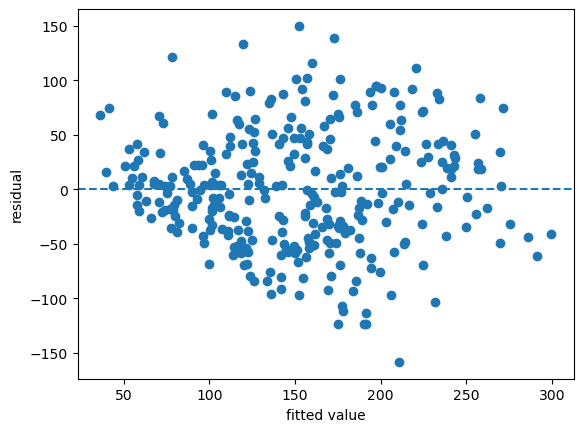

In [14]:
# 잔차의 전제조건 확인 
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle = "--")

- 등분산성 검정: 산점도 결과 경향성을 띠지 않아 등분산성을 띤다고 할 수 있다.
- Omnibus의 p_value는 0.593으로 유의수준 값 0.05보다 크다. 따라서 정규성을 띤다고 할 수 있다. 
- Jarque-Bera의 p_value는 0.515로 유의수준 값 0.05보다 크다.따라서 독립성을 띤다고 할 수 있다. 
- 따라서, 잔차의 기본 전제 조건을 모두 만족하였다. 

<Axes: >

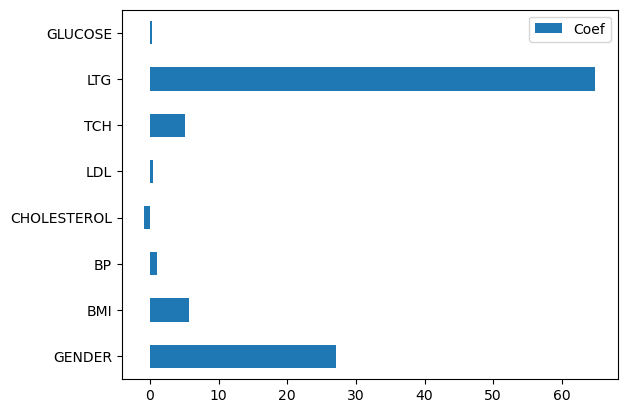

In [15]:
df_reg_coef = pd.DataFrame({"Coef":reg_result.params.values[1:]},
                          index = ['GENDER', 'BMI', 'BP', 'CHOLESTEROL', 'LDL', 'TCH', 'LTG', 'GLUCOSE'])
df_reg_coef.plot.barh(y="Coef")

#### step 4. 결론 도출 

- 변수들의 p_value를 통해 회귀계수의 유의성을 검정하고, VIF 값을 통해 다중공선성을 검정하였다. 
- 최종 모델의 회귀식은 다음과 같다.
    Y=−368.4824+27.1183⋅GENDER+5.6792⋅BMI+1.0701⋅BP−0.8093⋅CHOLESTEROL+0.5082⋅LDL+5.1096⋅TCH+64.8296⋅LTG+0.3077⋅GLUCOSE
- 중요도는 회귀계수의 절대값 크기와 같다. 따라서, LTG와 GENDER가 Y에 큰 영향을 미친다고 볼 수 있다. 
    

### 실습 2

#### Step 1. 데이터 불러오기 

In [16]:
df_raw_y = df_raw["Y"]
df_raw_x = df_raw.drop("Y", axis = 1, inplace = False)

In [17]:
#train/test 분리
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state = 240722)

print("trainx", df_train_x.shape)
print("trainY", df_train_y.shape)
print("test X", df_test_x.shape)
print("test Y", df_test_y.shape)

trainx (309, 10)
trainY (309,)
test X (133, 10)
test Y (133,)


#### Step 2. 규제화 회귀분석 파라미터 선정 

1) 규제화 회귀 모델 생성 : Ridge

In [18]:
# 모델 생성
ridge = Ridge(random_state=1234, alpha=1)
ridge.fit(df_train_x, df_train_y)
# 절편값 확인 
print(ridge.intercept_)

-282.8197599877476


In [19]:
# 회귀계수 확인 
df_ridge_coef = pd.DataFrame({"Coef":ridge.coef_}, index = df_train_x.columns)
df_ridge_coef.sort_values("Coef", ascending=False)

,Coef
LTG,46.211969
GENDER,25.019822
BMI,5.772692
TCH,1.161345
BP,1.149526
GLUCOSE,0.191040
AGE,0.059617
LDL,0.017631
CHOLESTEROL,-0.226340
HDL,-0.746454


<Axes: >

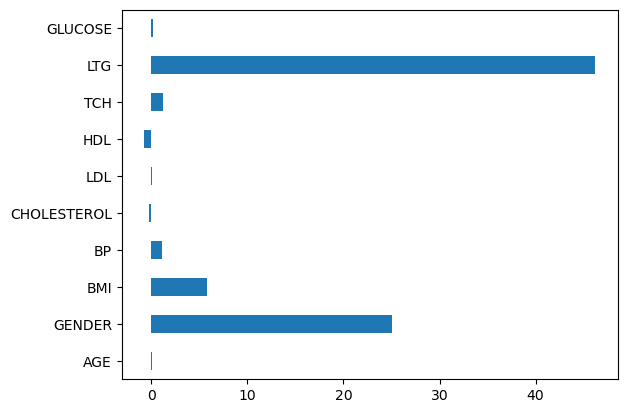

In [20]:
# 회귀계수 그래프 
df_ridge_coef.plot.barh(y="Coef", legend=False)

2) 규제화 회귀 모델 생성 : Lasso

In [21]:
# 모델 생성
lasso = Lasso(random_state=1234, alpha=1)
lasso.fit(df_train_x, df_train_y)  
# 절편값 확인
print(lasso.intercept_)

-186.74170489775324


In [22]:
# 회귀계수 확인
df_lasso_coef = pd.DataFrame({"Coef":lasso.coef_}, index = df_train_x.columns)
df_lasso_coef.sort_values("Coef", ascending=False)

,Coef
GENDER,20.306499
LTG,20.094942
BMI,5.956891
BP,1.131398
CHOLESTEROL,0.656883
GLUCOSE,0.203692
AGE,0.062426
TCH,-0.000000
LDL,-0.799541
HDL,-1.645954


<Axes: >

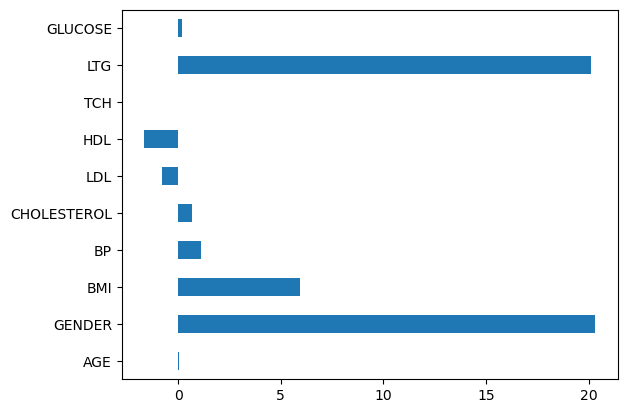

In [23]:
# 회귀계수 그래프
df_lasso_coef.plot.barh(y="Coef", legend=False)

3) 규제화 모델 생성 : ElasticNet

In [24]:
# 모델 생성
elastic = ElasticNet(random_state=1234, alpha=1, l1_ratio=0.7)
elastic.fit(df_train_x, df_train_y)
# 절편값 확인
print(elastic.intercept_)

-121.22030625527455


In [25]:
# 회귀계수 확인
df_elastic_coef = pd.DataFrame({"Coef":elastic.coef_}, index = df_train_x.columns)
df_elastic_coef.sort_values("Coef", ascending=False)

,Coef
GENDER,8.499343
BMI,6.175901
LTG,2.848963
CHOLESTEROL,1.252922
BP,1.048883
GLUCOSE,0.198429
AGE,0.046799
TCH,-0.000000
LDL,-1.384436
HDL,-2.068722


<Axes: >

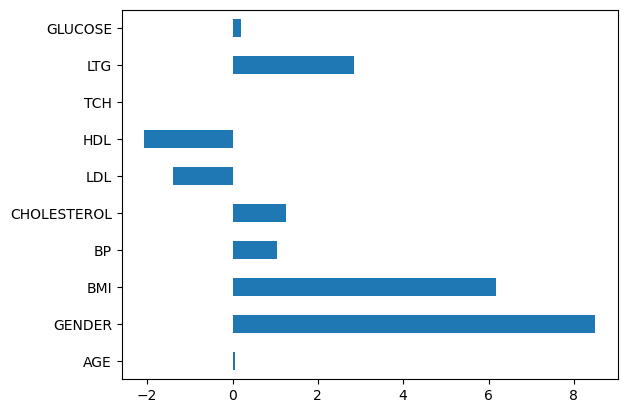

In [26]:
# 회귀계수 그래프
df_elastic_coef.plot.barh(y="Coef", legend=False)

In [27]:
# 예측
ridge_train_pred = ridge.predict(df_train_x)
ridge_test_pred = ridge.predict(df_test_x)

lasso_train_pred = lasso.predict(df_train_x)
lasso_test_pred = lasso.predict(df_test_x)

elastic_train_pred = elastic.predict(df_train_x)
elastic_test_pred = elastic.predict(df_test_x)

# R²(결정계수) 계산
ridge_train_r2 = r2_score(df_train_y, ridge_train_pred)
ridge_test_r2 = r2_score(df_test_y, ridge_test_pred)

lasso_train_r2 = r2_score(df_train_y, lasso_train_pred)
lasso_test_r2 = r2_score(df_test_y, lasso_test_pred)

elastic_train_r2 = r2_score(df_train_y, elastic_train_pred)
elastic_test_r2 = r2_score(df_test_y, elastic_test_pred)

print("Ridge Train R2 : ", ridge_train_r2)
print("Ridge Test R2 : ", ridge_test_r2)
print()
print("Lasso Train R2 : ", lasso_train_r2)
print("Lasso Test R2 : ", lasso_test_r2)
print()
print("Elastic Train R2 : ", elastic_train_r2)
print("Elastic Test R2 : ", elastic_test_r2)

Ridge Train R2 :  0.5185035908131592
Ridge Test R2 :  0.5038378280198894

Lasso Train R2 :  0.5128357139233934
Lasso Test R2 :  0.4893628957433943

Elastic Train R2 :  0.49694581382027836
Elastic Test R2 :  0.4743806328359441


- Ridge
    - Ridge 회귀 모델은 훈련 데이터와 테스트 데이터 모두에서 높은 결정계수를 보인다. 두 결정계수의 차이가 적기 때문에 과적합(overfitting)의 우려도 적다.
- Lasso
    - Lasso 모델은 훈련 데이터와 테스트 데이터에서 Ridge 회귀 모델보다 약간 낮은 결정계수를 보인다. 이는 Lasso가 일부 feature를 제거하고 모델을 단순화하기 때문일 수 있다. 두 결정계수의 차이가 크지 않아 과적합의 문제는 없을 듯 보인다. 
- ElasticNet
    - ElasticNet 회귀 모델은 Ridge와 Lasso에 비해 결정계수가 다소 낮다. 이는 ElasticNet이 L1과 L2 정규화를 동시에 작용하기 때문이라고 생각된다. 두 결정계수의 차이가 상대적으로 작기 때문에 과적합의 문제는 크지 않다.

#### Step 3. 최종 규제화 회귀 모델 생성

- 결정계수와 일반화 능력을 고려할 때, Ridge Regression이 가장 좋은 성능을 보인다. 
- 최종 모델은 Ridge로 선정한다. 

In [28]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터
ridge = Ridge(random_state=1234)
param_grid = {'alpha': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(df_train_x, df_train_y)

print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 모델 학습
final_model = grid_search.best_estimator_
final_model.fit(df_train_x, df_train_y)

# 최종 모델 평가
train_r2 = final_model.score(df_train_x, df_train_y)
test_r2 = final_model.score(df_test_x, df_test_y)

print("최종 모델 Train R²: {0:.3f}".format(train_r2))
print("최종 모델 Test R²: {0:.3f}".format(test_r2))

최적의 하이퍼파라미터: {'alpha': 1.0}
최종 모델 Train R²: 0.519
최종 모델 Test R²: 0.504


In [30]:
# 평가용 데이터에 대한 실제값과 예측값 확인 
final_model_pred = final_model.predict(df_test_x)
final_result = pd.DataFrame({'real_y': df_test_y, 'final_y': final_model_pred})
final_result.head(10)

,real_y,final_y
43,92,80.775841
159,195,238.391640
319,191,188.600600
52,59,135.748177
259,50,145.859983
94,90,109.458747
373,168,144.080144
371,197,207.183925
40,100,151.411282
252,91,181.510264
